**PPO Cartpole Implementation**

PPO Paper: [https://arxiv.org/pdf/1707.06347](https://arxiv.org/pdf/1707.06347)

PPO Cartpole implementation based on this [Medium](https://medium.com/deeplearningmadeeasy/simple-ppo-implementation-e398ca0f2e7c) article and this previous [implementation](https://github.com/adi3e08/PPO/tree/main).


In [27]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from matplotlib import pyplot as plt

In [28]:
class CartpoleEnvironment:
  def __init__(self):
    self.env = gym.make('CartPole-v1')
    self.state_dim = self.env.observation_space.shape[0]  
    self.action_dim = self.env.action_space.n
    self.num_steps = 0

    self.running_mean = np.zeros(self.state_dim)
    self.running_std = np.ones(self.state_dim)
    

  # normalize input state based off the running mean and std deviation
  def norm_state(self, state):
    # https://builtin.com/articles/mean-normalization
    state_array = np.array(state)
    normalized_state = (state_array - self.running_mean) / (self.running_std + 1e-8)
    return normalized_state
  
  # update running mean and running std deviation after processing state
  def update_state_norm(self, state):
    self.num_steps += 1
    state_array = np.array(state)
    
    # https://stackoverflow.com/questions/12636613/how-to-calculate-moving-average-without-keeping-the-count-and-data-total
    self.running_mean = self.running_mean * ((self.num_steps - 1) / self.num_steps) + state_array * (1 / self.num_steps)

    # https://stackoverflow.com/questions/1174984/how-to-efficiently-calculate-a-running-standard-deviation
    squared_diff = (state_array - self.running_mean) ** 2
    self.running_std = np.sqrt(self.running_std ** 2 * ((self.num_steps-1)/self.num_steps) + squared_diff * (1/self.num_steps))
    
  def step(self, action):
    next_state, reward, terminated, truncated, info = self.env.step(action)
    self.update_state_norm(next_state)
    normalized_next_state = self.norm_state(next_state)
    isDone = terminated or truncated
    return normalized_next_state, reward, isDone, info
    
  def reset(self):
    state, _ = self.env.reset()
    self.update_state_norm(state)
    normalized_state = self.norm_state(state)
    return normalized_state

In [29]:
class ActorNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super(ActorNetwork, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, hidden_dim).double(),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim).double(),
            nn.Tanh(),
            nn.Linear(hidden_dim, action_dim).double()
        )
    
    def forward(self, state):
        return F.softmax(self.actor(state), dim=-1)

class CriticNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim=64):
        super(CriticNetwork, self).__init__()
        self.critic = nn.Sequential(
            nn.Linear(state_dim, hidden_dim).double(),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim).double(),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1).double()
        )
    
    def forward(self, state):
        return self.critic(state)

In [30]:
class PPOBatch:
    def __init__(self, batch_size=32):
        self.states = []
        self.actions = []
        self.rewards = []
        self.next_states = []
        self.isDonearr = []
        self.state_values = []
        self.log_probabilities = []
        self.batch_size = batch_size
        
    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]
        return batches

    def store(self, state, action, reward, next_state, done, value, log_prob):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.next_states.append(next_state)
        self.isDonearr.append(done)
        self.state_values.append(value)
        self.log_probabilities.append(log_prob)
    
    def clear(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.next_states = []
        self.isDonearr = []
        self.state_values = []
        self.log_probabilities = []


In [33]:
class PPOAgent:
    def __init__(self, state_dim, action_dim):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # hyperparameters
        self.gamma = 0.99
        self.gae_lambda = 0.98
        self.clip_epsilon = 0.2
        self.critic_coef = 0.5
        self.max_grad_norm = 0.5
        self.batch_size = 64
        self.n_epochs = 10
        self.buffer_size = 4096
        
        # actor and critic networks
        self.actor = ActorNetwork(state_dim, action_dim).to(self.device)
        self.critic = CriticNetwork(state_dim).to(self.device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=8e-3)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)
        self.actor_scheduler = optim.lr_scheduler.StepLR(self.actor_optimizer, step_size=200, gamma=0.9)
        self.critic_scheduler = optim.lr_scheduler.StepLR(self.critic_optimizer, step_size=200, gamma=0.9)
        
        # batch size storage
        self.memory = PPOBatch(batch_size=self.batch_size)
        
        self.episode_rewards = []
        self.average_rewards = []

    def select_action(self, state):
        with torch.no_grad():
            state = torch.DoubleTensor(state).to(self.device)
            action_probabilities = self.actor(state)
            dist = Categorical(action_probabilities)
            action = dist.sample()
            action_log_probabilities = dist.log_prob(action)
            state_value = self.critic(state)
            
        return action.item(), action_log_probabilities.item(), state_value.item()

    def generalized_advantage_estimation(self, rewards, values, next_values, isDonearr):
        advantages = np.zeros_like(rewards)
        prev_generalized_advantage_estimation = 0
        
        for t in reversed(range(len(rewards))):
            if t == len(rewards) - 1:
                next_value = next_values[t]
            else:
                next_value = values[t + 1]
            
            # calculate the temporal difference in gae
            delta = rewards[t] + self.gamma * next_value * (1 - isDonearr[t]) - values[t]
            # update step for the gae
            advantages[t] = prev_generalized_advantage_estimation = delta + self.gamma * self.gae_lambda * (1 - isDonearr[t]) * prev_generalized_advantage_estimation
            
        returns = advantages + values
        return returns, advantages

    def update(self):
        states = torch.DoubleTensor(np.array(self.memory.states)).to(self.device)
        actions = torch.LongTensor(np.array(self.memory.actions)).to(self.device)
        old_log_probs = torch.DoubleTensor(np.array(self.memory.log_probabilities)).to(self.device)
        values = np.array(self.memory.state_values)
        
        with torch.no_grad():
            next_states = torch.DoubleTensor(np.array(self.memory.next_states)).to(self.device)
            next_values = self.critic(next_states).cpu().numpy().flatten()
        
        # calculate returns and advantages
        returns, advantages = self.generalized_advantage_estimation(
            np.array(self.memory.rewards),
            values,
            next_values,
            np.array(self.memory.isDonearr)
        )
        
        returns = torch.DoubleTensor(returns).to(self.device)
        advantages = torch.DoubleTensor(advantages).to(self.device)
        
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # ppo update
        for _ in range(self.n_epochs):
            batch_indices = self.memory.generate_batches()
            
            for batch_idx in batch_indices:
                batch_states = states[batch_idx]
                batch_actions = actions[batch_idx]
                batch_old_log_probs = old_log_probs[batch_idx]
                batch_returns = returns[batch_idx]
                batch_advantages = advantages[batch_idx]
                
                action_probs = self.actor(batch_states)
                dist = Categorical(action_probs)
                current_log_probs = dist.log_prob(batch_actions)
                entropy = dist.entropy().mean()
                current_values = self.critic(batch_states).squeeze()
                
                # probability ratio and surrogate functions
                ratios = torch.exp(current_log_probs - batch_old_log_probs)
                surr1 = ratios * batch_advantages
                surr2 = torch.clamp(ratios, 1-self.clip_epsilon, 1+self.clip_epsilon) * batch_advantages
                
                # loss calculations
                actor_loss = -torch.min(surr1, surr2).mean()
                critic_loss = F.smooth_l1_loss(current_values, batch_returns)  # Huber loss for more robust value estimation
                self.actor_optimizer.zero_grad()
                actor_total_loss = actor_loss
                actor_total_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.actor.parameters(), self.max_grad_norm)
                self.actor_optimizer.step()
                
                # update critic
                self.critic_optimizer.zero_grad()
                critic_loss = self.critic_coef * critic_loss
                critic_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.critic.parameters(), self.max_grad_norm)
                self.critic_optimizer.step()
        
        self.memory.clear()

    def train(self, num_episodes=1500):
        env = CartpoleEnvironment()
        best_reward = 0
        steps_since_update = 0
        
        for episode in range(num_episodes):
            state = env.reset()
            episode_reward = 0
            done = False
            
            while not done:
                steps_since_update += 1
                action, log_prob, value = self.select_action(state)
                next_state, reward, done, _ = env.step(action)
                self.memory.store(state, action, reward, next_state, done, value, log_prob)
                
                state = next_state
                episode_reward += reward
                
                if steps_since_update >= self.buffer_size:
                    self.update()
                    steps_since_update = 0
            
            self.episode_rewards.append(episode_reward)
            
            # calculate average reward for smoother graph visuals
            if len(self.episode_rewards) >= 100:
                avg_reward = np.mean(self.episode_rewards[-100:])
                self.average_rewards.append(avg_reward)
                
                if avg_reward >= 475:  # CartPole-v1 solving criterion
                    print(f"\nEnvironment solved in {episode + 1} episodes!")
                    return self.episode_rewards, self.average_rewards  # Return immediately when solved
                
                if avg_reward > best_reward:
                    best_reward = avg_reward
            else:
                avg_reward = np.mean(self.episode_rewards)
                self.average_rewards.append(avg_reward)
            
            if (episode + 1) % 20 == 0:
                print(f"Episode {episode + 1}, Average Reward: {avg_reward:.2f}")
        
        return self.episode_rewards, self.average_rewards

Episode 20, Average Reward: 21.20
Episode 40, Average Reward: 21.23
Episode 60, Average Reward: 20.58
Episode 80, Average Reward: 21.45
Episode 100, Average Reward: 21.59
Episode 120, Average Reward: 21.56
Episode 140, Average Reward: 21.52
Episode 160, Average Reward: 21.64
Episode 180, Average Reward: 21.28
Episode 200, Average Reward: 22.67
Episode 220, Average Reward: 23.31
Episode 240, Average Reward: 24.90
Episode 260, Average Reward: 27.06
Episode 280, Average Reward: 28.74
Episode 300, Average Reward: 30.58
Episode 320, Average Reward: 32.32
Episode 340, Average Reward: 43.00
Episode 360, Average Reward: 51.84
Episode 380, Average Reward: 63.83
Episode 400, Average Reward: 76.54
Episode 420, Average Reward: 93.07
Episode 440, Average Reward: 102.41
Episode 460, Average Reward: 120.67
Episode 480, Average Reward: 138.95
Episode 500, Average Reward: 159.35
Episode 520, Average Reward: 186.21
Episode 540, Average Reward: 242.88
Episode 560, Average Reward: 304.27
Episode 580, Aver

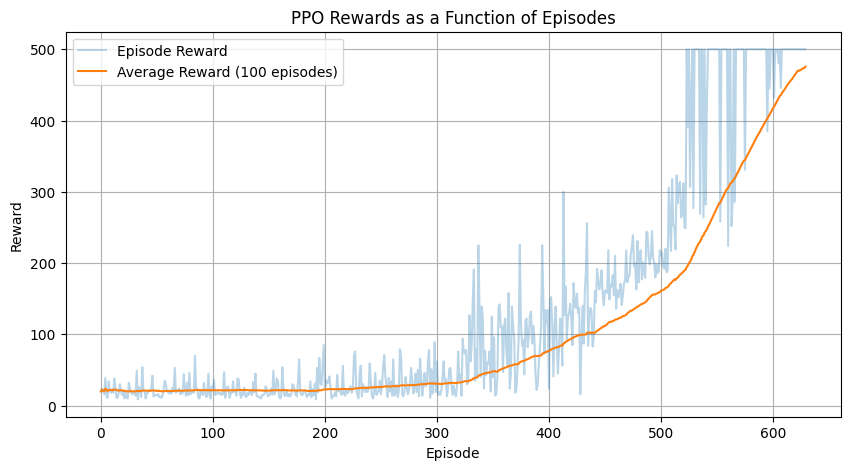

In [34]:
def main():
    env = CartpoleEnvironment()
    agent = PPOAgent(env.state_dim, env.action_dim)
    rewards, average_rewards = agent.train()
    
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label='Episode Reward', alpha=0.3)
    plt.plot(average_rewards, label='Average Reward (100 episodes)')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('PPO Rewards as a Function of Episodes')
    plt.legend()
    plt.grid()
    plt.show()

if __name__ == "__main__":
    main()